In [1]:
import collections
import glob
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import pickle
import random

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

all_N = [10, 20, 50, 100, 200, 500, 800, 1000, 2000, 5000]
colors = plt.cm.tab10.colors

In [2]:
experi = {}
allN = set()
allM = set()
for N in [10, 20, 50, 100, 200, 500, 800, 1000]:
    path = glob.glob(
        "./gradient_descent_results/N_" + str(N) + "_png/*seed_[0-9].png"
    ) + glob.glob(
        "./gradient_descent_results/N_" + str(N) + "_png/*seed_[0-9]_true.png"
    )

    for p_ in path:
        params = p_.split("/")[-1].replace(".png", "").split("_")

        N_, M_, P_, seed_ = (
            int(params[1]),
            int(params[3]),
            int(params[5]),
            int(params[7]),
        )
        if M_ == 20:
            continue
        if M_ == 15 and N_ == 1000:
            continue
        if (N_, M_) not in experi:
            experi[(N_, M_)] = {}
        if P_ not in experi[(N_, M_)]:
            experi[(N_, M_)][P_] = np.ones((20,), dtype=int) * np.nan

        if experi[(N_, M_)][P_][seed_] > 0:
            continue
        else:
            experi[(N_, M_)][P_][seed_] = int(params[-1] == "true")

        if N_ not in allN:
            allN.add(N_)
        if M_ not in allM:
            allM.add(M_)

    for N_, M_ in experi:
        for P_ in experi[(N_, M_)]:
            experi[(N_, M_)][P_] = experi[(N_, M_)][P_][~np.isnan(experi[(N_, M_)][P_])]
        experi[(N_, M_)] = collections.OrderedDict(sorted(experi[(N_, M_)].items()))


In [3]:
arrayN = np.array(sorted(list(allN)))
arrayM = np.array(sorted(list(allM)))
countTrialDict = {}
for N in arrayN:
    for M in arrayM:
        if (N, M) in experi:
            countTrial = []
            for k in experi[(N, M)]:
                countTrial.append(
                    (
                        k,
                        k / N,
                        len(experi[(N, M)][k]),
                        sum(experi[(N, M)][k]) / len(experi[(N, M)][k]),
                    )
                )
            countTrialDict[(N, M)] = countTrial
        else:
            countTrialDict[(N, M)] = []

In [4]:
arrayN, arrayM

(array([  10,   20,   50,  100,  200,  500,  800, 1000]),
 array([ 2,  3,  5, 10, 15]))

## Fig 2 c-e

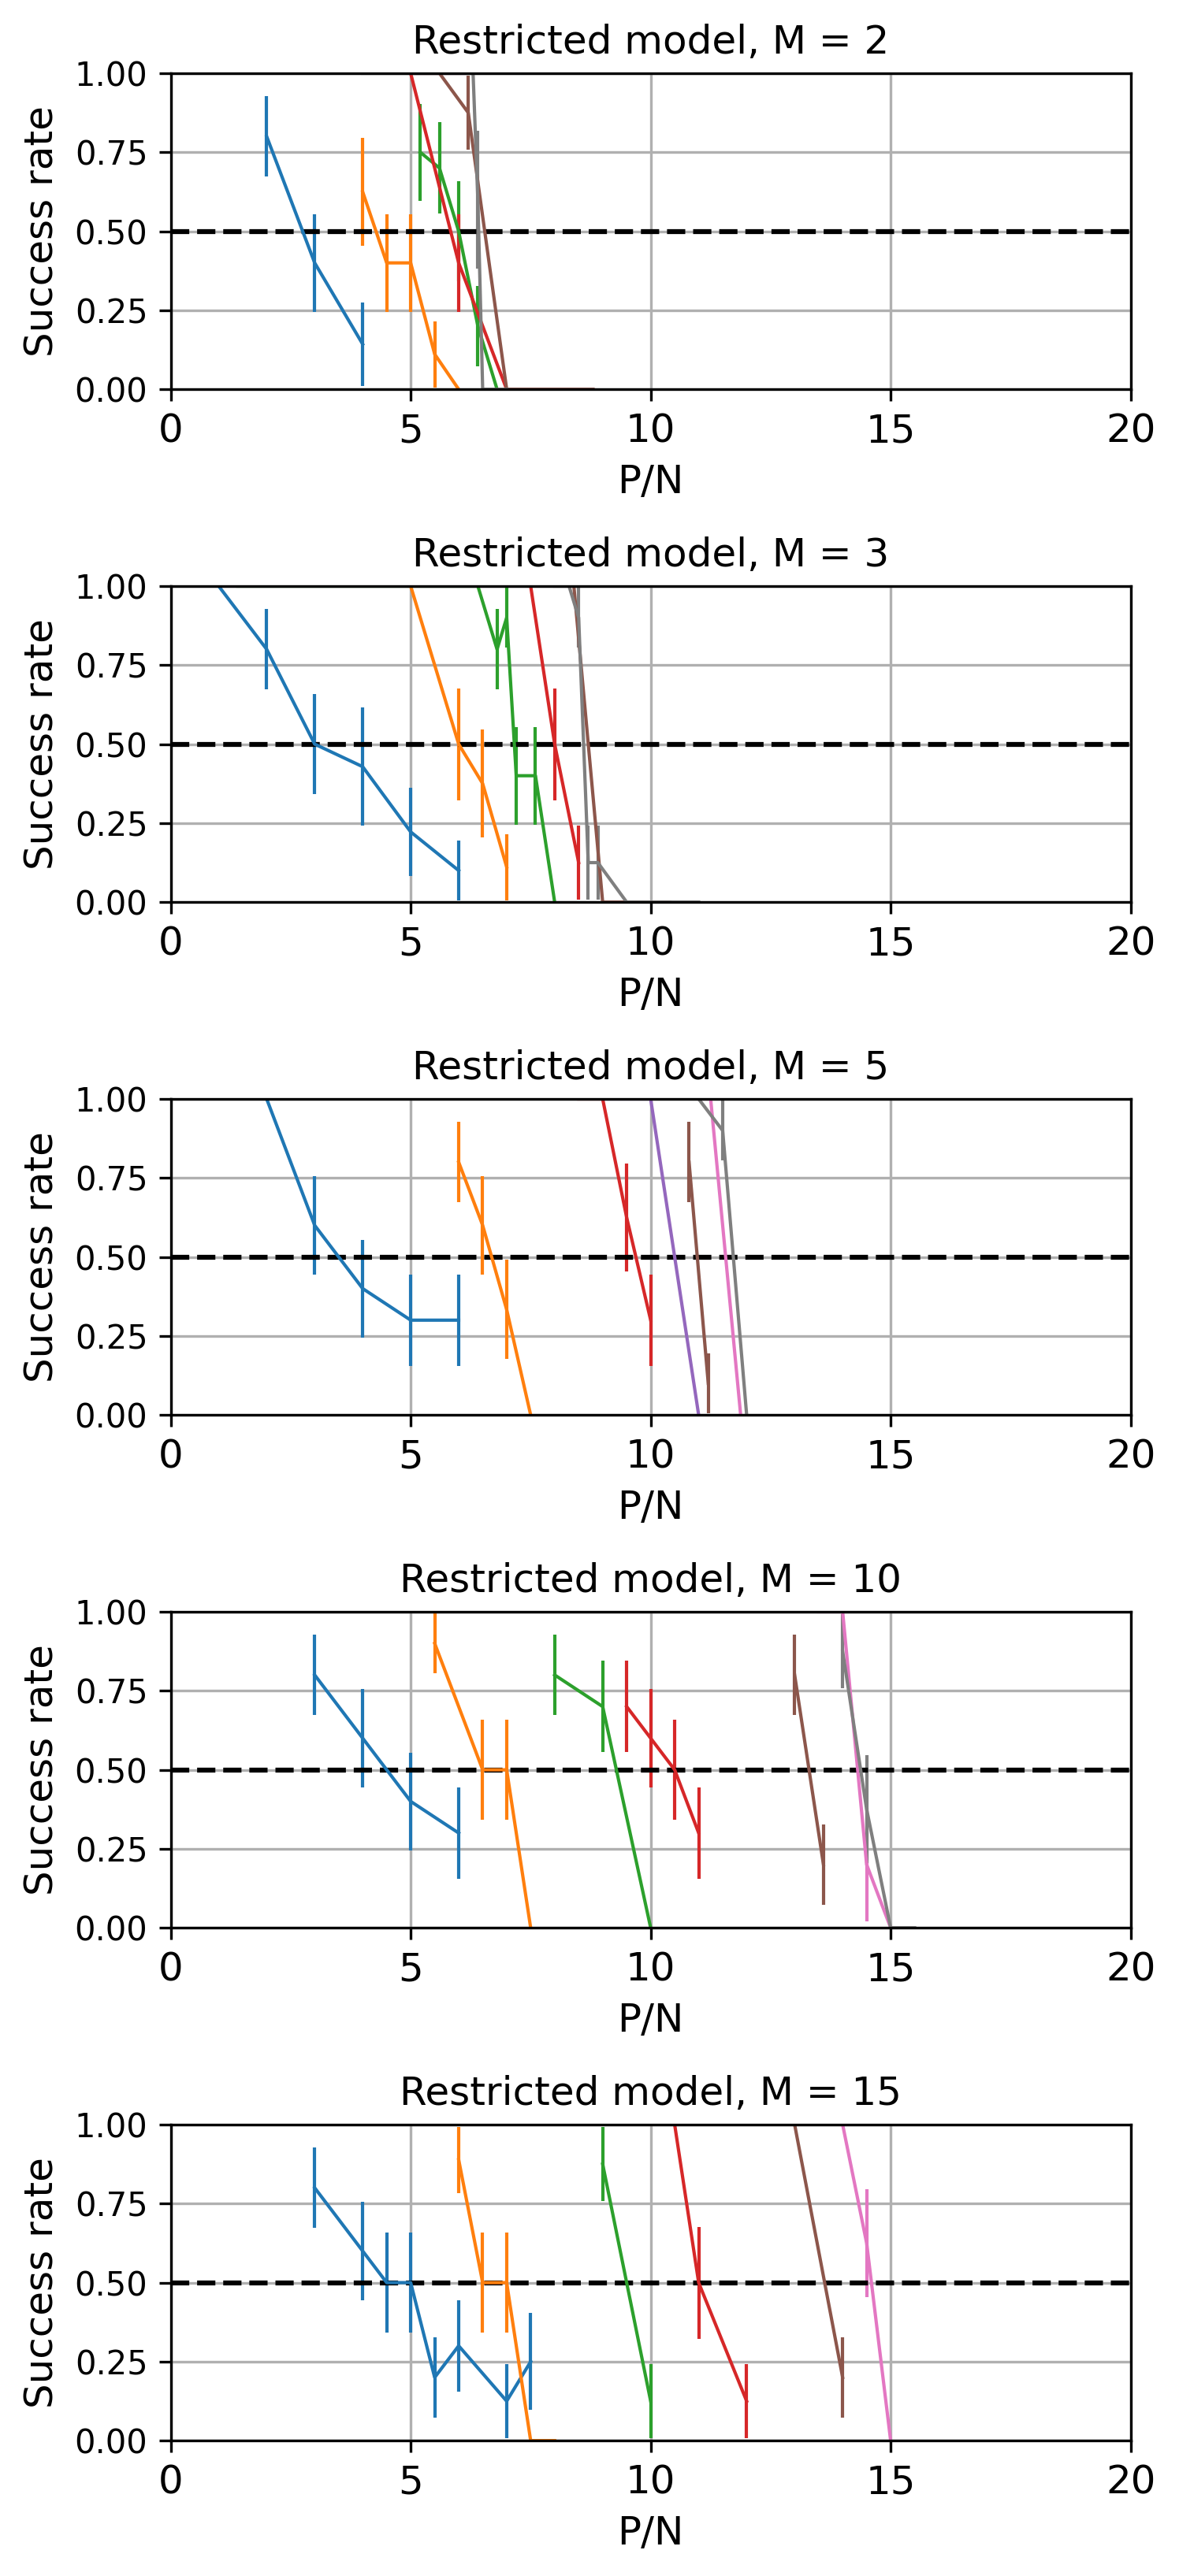

In [5]:
plt.figure(figsize=(5, 11), dpi=300)
# plt.plot([3,14],[.5,.5],'k--')
c = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:olive",
    "tab:cyan",
]

arrayN = np.array(sorted(list(allN)))
arrayM = np.array(sorted(list(allM)))
capacity = {}
sample_ratio = 0.5
for count, (N, M) in enumerate(experi):
    # if M not in {2,3,5}:
    #     continue
    if M not in capacity:
        capacity[M] = []

    sample = 100
    psedoC = []
    for i in range(sample):
        psedoX = []
        psedoY = []

        for P in experi[(N, M)]:
            psedoX += [P / N] * int(len(experi[(N, M)][P]) * sample_ratio)
            psedoY += random.sample(
                list(experi[(N, M)][P]), k=int(len(experi[(N, M)][P]) * sample_ratio)
            )
        if min(psedoY) == max(psedoY):
            continue
        clf = LogisticRegression(penalty="none").fit(
            np.array(psedoX).reshape(-1, 1), np.array(psedoY)
        )
        newX = np.linspace(
            min(experi[(N, M)].keys()) / N, max(experi[(N, M)].keys()) / N, 20
        )
        if np.abs(-clf.intercept_[0] / clf.coef_[0][0]) > 20:
            continue
        psedoC.append(-clf.intercept_[0] / clf.coef_[0][0])

        probs = clf.predict_proba(newX.reshape(-1, 1))

        # plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
        # plt.plot(
        #     newX,
        #     probs[:, 1],
        #     alpha=0.15,
        #     linewidth=0.5,
        #     color=c[np.where(arrayN == N)[0][0]],
        # )

    capacity[M].append(
        [N, M, np.nanmean(np.array(psedoC)), np.nanstd(np.array(psedoC))]
    )

    plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
    plt.errorbar(
        np.array(list(experi[(N, M)].keys())) / N,
        [np.mean(np.array(experi[(N, M)][P])) for P in experi[(N, M)]],
        yerr=[
            np.std(np.array(experi[(N, M)][P])) / np.sqrt(len(experi[(N, M)][P]))
            for P in experi[(N, M)]
        ],
        label="N=" + str(N),
        linewidth=1,
        # color=c[np.where(arrayN == N)[0][0]],
        color=colors[all_N.index(N)],
    )

    # plt.errorbar(
    #     [np.array(psedoC).mean()],
    #     [0.5],
    #     xerr=np.array(psedoC).std(),
    #     fmt="o",
    #     linewidth=2,
    #     capsize=2,
    #     color=c[np.where(arrayN == N)[0][0]],
    # )

for i in range(arrayM.size):
    plt.subplot(arrayM.size, 1, i + 1)
    plt.title("Restricted model, M = " + str(arrayM[i]), fontsize=12)
    # if i == 0 or i == 2:
    #     plt.legend(fontsize=9)
    plt.xlim([0, 20])
    plt.ylim([0, 1])
    plt.plot([0, 20], [0.5, 0.5], "k--")
    plt.xticks([0, 5, 10, 15, 20], fontsize=12)
    plt.grid()
    plt.xlabel("P/N", fontsize=12)
    plt.ylabel("Success rate", fontsize=12)

for M in capacity:
    capacity[M] = np.array(capacity[M])
capacity = collections.OrderedDict(sorted(capacity.items()))
with open("capacity_restricted_model.pkl", "wb") as f:
    pickle.dump(capacity, f, protocol=pickle.HIGHEST_PROTOCOL)

plt.tight_layout()
plt.savefig("success_rate.pdf")
plt.show()

## Fig 2f

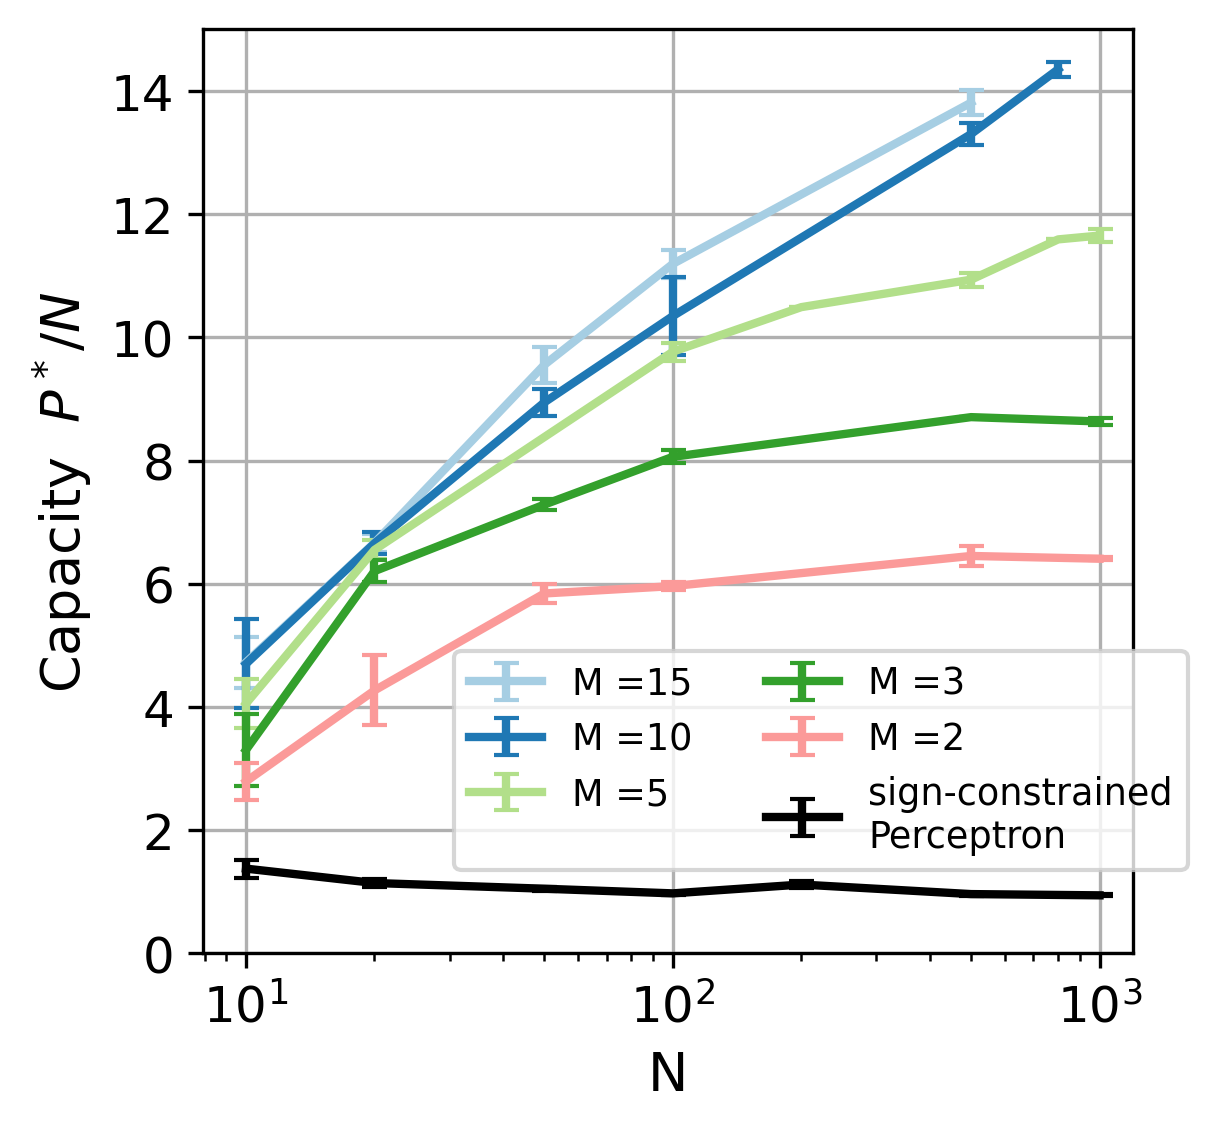

In [18]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

# Get the 'Pastel1' colormap
cmap = plt.cm.get_cmap("Paired")

# Define the number of discrete colors you want
num_colors = 5

# Get the discrete colors from the colormap
color = [cmap(i) for i in range(num_colors)]

# color =  ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
# plt.errorbar(capacityms[:, 0], capacityms[:, 1], yerr =capacityms[:, 2], \
#                 capsize = 3, color = 'red' , label = 'Unrestricted', linewidth = 3, zorder = 10)
for i, M in [(0, 15), (1, 10), (2, 5), (3, 3), (4, 2)]:
    if M == 15:
        plt.errorbar(
            capacity[M][:-1, 0],
            capacity[M][:-1, 2],
            yerr=capacity[M][:-1, 3],
            capsize=3,
            color=color[i],
            label="M =" + str(M),
            linewidth=2,
        )
        continue
    if M == 10:
        plt.errorbar(
            capacity[M][:-1, 0],
            capacity[M][:-1, 2],
            yerr=capacity[M][:-1, 3],
            capsize=3,
            color=color[i],
            label="M =" + str(M),
            linewidth=2,
        )
        continue
    x, y, yerr = capacity[M][:, 0], capacity[M][:, 2], capacity[M][:, 3]

    plt.errorbar(
        x[~np.isnan(y)],
        y[~np.isnan(y)],
        yerr=yerr[~np.isnan(y)],
        capsize=3,
        color=color[i],
        label="M =" + str(M),
        linewidth=2,
    )

distribution = "uniform"
learning_rule = "amit"
with open(
    "perceptron_sign_constrained_capacity_{}_{}.pkl".format(
        distribution, learning_rule
    ),
    "rb",
) as f:
    capacity_perceptron_sign_constrained = pickle.load(f)
capacity_perceptron_sign_constrained = np.array(capacity_perceptron_sign_constrained)

# capacity_no_limit = capacity_no_limit[5]
plt.errorbar(
    capacity_perceptron_sign_constrained[:, 0],
    capacity_perceptron_sign_constrained[:, 1],
    yerr=capacity_perceptron_sign_constrained[:, 2],
    capsize=3,
    linewidth=2,
    color="k",
    label="sign-constrained\nPerceptron",
)
# handles, labels = ax.get_legend_handles_labels()
# # put the perceptron label at the last
# handles = handles[1:] + [handles[0]]
# labels = labels[1:] + [labels[0]]
# plt.legend(handles, labels, prop={"size": 10}, loc="upper left")
plt.legend(prop={"size": 8.8}, loc=[0.27, 0.09], ncol=2)
plt.xscale("log")
plt.grid()

plt.xlabel("N", fontsize=13)
plt.ylabel("Capacity " + r" $P^*/N $", fontsize=13)
plt.xlim([-15, 1.2e3])
plt.ylim([0, 15])

# plt.tight_layout()

plt.savefig("capacity_restricted_model.pdf")

In [7]:
from parallel_synapse_gradient import *


class args:
    def init(self):
        N = 0
        M = 0
        seed = 0
        P = 0


args.N, args.M, args.seed, args.P = 1000, 5, 0, 11000
allActv = []
# for args.seed in range(10):
model_params = {
    "N": args.N,  # input dimension
    "M": args.M,  # parallel synapse number
    "seed": args.seed,
    "device": torch.device("cpu"),
}
train_params = {
    "margin": 0.1,  # only applied when 'loss' is hinge
    "threslr": 1e-6,
    "adamlr": 0.003,
    "minAmpli": 1e-1,
    "Nepoch": 160000,
    "P": args.P,
    "maxRecord": 4000,
    "downSample": 100,
    "NthresPool": int(args.P / 2),
}
path = ""
folder = "./N_" + str(model_params["N"])
# folder = './monsyn4'
#
path += (
    "N_"
    + str(model_params["N"])
    + "_M_"
    + str(model_params["M"])
    + "_P_"
    + str(train_params["P"])
    + "_seed_"
    + str(model_params["seed"])
)

data_ = load_model(folder + "/" + path + "_data")
inputX, label = (
    data_[:, :-1].to(model_params["device"]),
    data_[:, -1].to(model_params["device"]),
)


model = ParallelSyn(model_params)


state_dict = torch.load(folder + "/" + path, map_location=model_params["device"])
model.load_state_dict(state_dict, strict=False)

actv = inputX.unsqueeze(2) - model.thres.unsqueeze(0)
actv = actv * model.slope.unsqueeze(0)
actv = torch.tanh(actv)
actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)
allActv.append(
    (actv.detach().numpy() - np.median(actv.detach().numpy(), axis=0)).ravel()
)

## Fig 2g

In [8]:
def plot_activation(model, n, file):
    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]

    nX = 5000
    """
    plot the staircase functions
    """
    thresMin = model.thres.min().item()
    thresMax = model.thres.max().item()
    x = torch.tile(
        torch.linspace(thresMin - 0.1, thresMax + 0.1, nX).unsqueeze(1), (1, nDim)
    )

    actv = x.unsqueeze(2) - model.thres.unsqueeze(0)
    actv = actv * model.slope.unsqueeze(0)
    actv = (torch.tanh(actv) + 1) / 2
    actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)

    actv = actv.detach().numpy()

    #     for i in range(n):
    #         actv[:, i] = actv[:, i] - np.median(actv[:, i]) + np.random.rand()
    x = x[:, 0]
    x = x.numpy()
    #     plt.rcParams["figure.figsize"] = (8,5)
    plt.rcParams.update({"font.size": 12})
    plt.figure(figsize=(3.5, 3.5), dpi=300)
    #     plt.subplot(1,2,1)
    #     plt.plot(x, actv)
    #     plt.xlabel('x')
    #     plt.ylabel('activation functions')
    #     if data['loss'][-1] == 0:
    #         plt.title('nDimension'+str(N) +', nSynapse '+str(M)+', nSample '+str(P)+'\n successfully classify all points')
    #     else:
    #         plt.title('nDimension'+str(N) +', nSynapse '+str(M)+', nSample '+str(P)+ '\n failed to classify all points')
    #     plt.title()
    #     plt.subplot(1,2,2)
    plt.plot(
        x,
        actv[:, :n] / np.max(actv[:, :n], axis=0, keepdims=True),
        linestyle="-",
        linewidth=1,
        alpha=1,
    )
    # plt.plot(x, actv[:, :n], linestyle = '-', alpha = .8)
    plt.xlim([-0.1, 1.1])
    #     plt.ylim([0,.6])
    plt.xlabel("Input")
    # plt.ylabel('arbitrary unit')
    plt.ylabel("Aggregate synaptic function")
    plt.tight_layout()
    plt.savefig("activation" + file + ".pdf")
    plt.show()

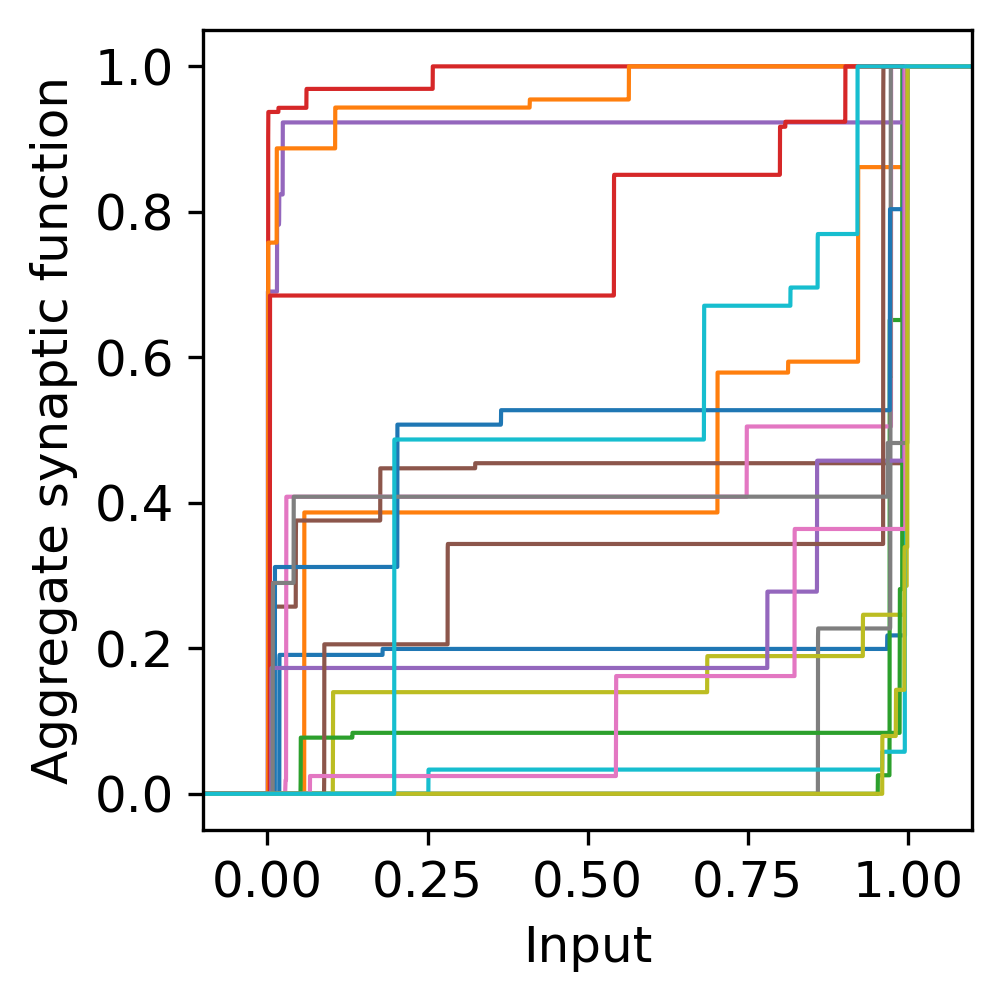

In [9]:
plot_activation(model, 20, "")

## Fig h - j

In [10]:
def thres_ampli(model):
    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]
    ampli = model.ampli.detach() ** 2

    thres = model.thres.detach()
    nBin = 20
    thresBin = np.linspace(thres.min(), thres.max(), nBin)
    allAmpli = []
    for i in range(1, nBin):
        ampli_ = ampli[(thres > thresBin[i - 1]) * (thres <= thresBin[i])]
        allAmpli.append([ampli_.mean(), ampli_.std() / np.sqrt(len(ampli_))])
    allAmpli = np.array(allAmpli)

    # allAmpli = allAmpli[allAmpli>0.1]
    plt.figure(figsize=(9, 3.0), dpi=300)
    plt.subplot(1, 3, 1)
    #     y, bins = np.histogram(ampli.ravel(), bins = 50)
    #     plt.bar(bins[1:], y/y.sum())
    plt.hist(ampli.ravel(), bins=100)
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")
    # plt.title('amplitude histogram')
    plt.subplot(1, 3, 2)
    plt.hist(thres.ravel(), bins=50)
    # y, bins = np.histogram(thres.ravel(), bins = 50)
    # plt.bar(bins[1:], y/y.sum())
    plt.xlabel("Threshold")
    plt.ylabel("Frequency")
    # plt.title('threshold histogram')

    plt.subplot(1, 3, 3)

    plt.errorbar(thresBin[1:], allAmpli[:, 0], yerr=allAmpli[:, 1])
    plt.xlabel("Threshold")
    plt.ylabel("Amplitude ")
    # plt.title('amplitude vs threshold')
    plt.tight_layout()
    plt.xticks([0, 0.5, 1])
    plt.savefig("ampli_thres1.pdf")
    plt.show()

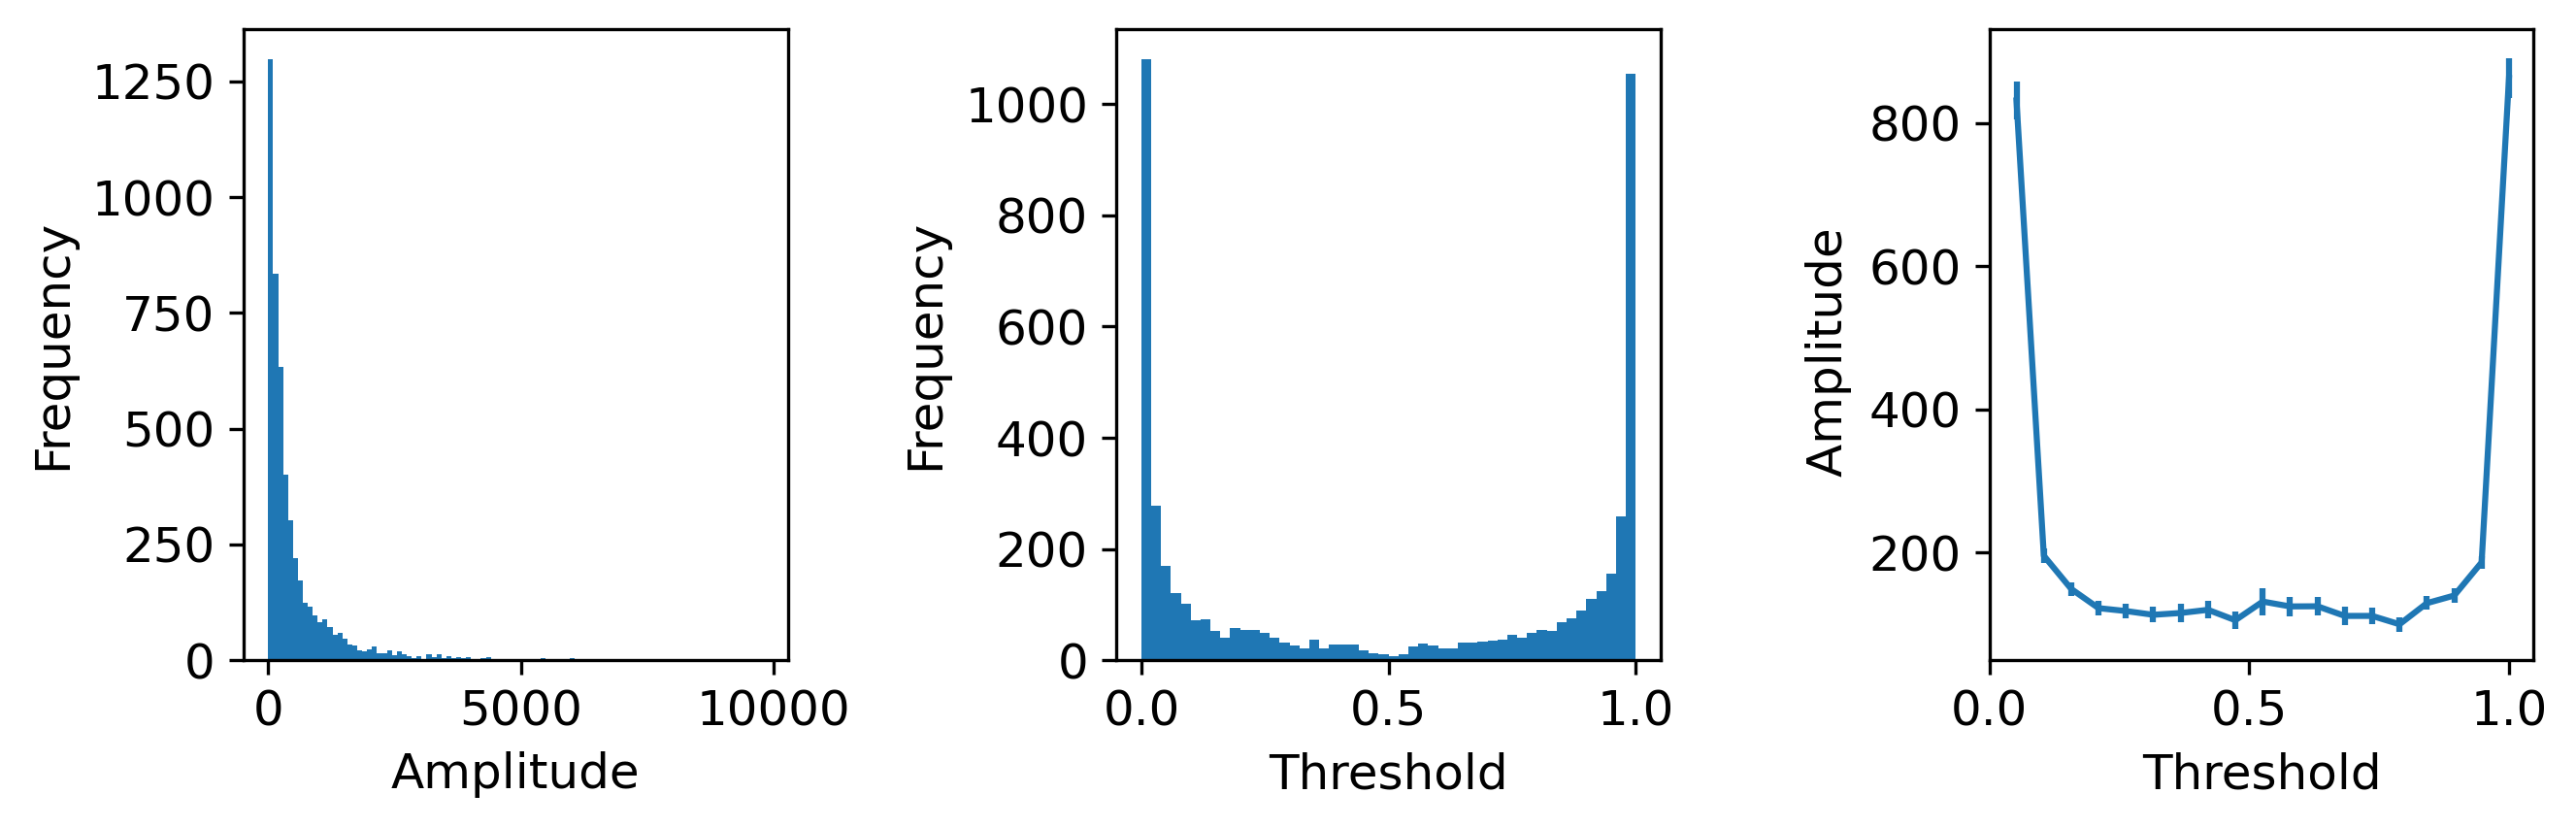

In [11]:
thres_ampli(model)